# Modeling and Simulation in Python

Project 2

Maalvika Bhat & Richard Gao

In [290]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [291]:
# Calculate the heat necessary to melt .05 kg of ice
m_solid = .05
latent_heat_fusion = 3.3 * 10 ** 5
q = m_solid * latent_heat_fusion

16500.0

In [292]:
human_specific_heat_capacity = 3500
mass_hand = 70 * 0.58 # Avg human male is 70kg and hand takes up 0.58% of body weight

40.599999999999994

In [293]:
# Specify material information
material_info = {'material': ['aluminum', 'nickel', 'marble', 'wood'],
                 'thermal_conductivity_factor': [205, 91, 2.5, 0.16],
                 'specific_heat_capacity': [897, 461, 880, 2000],
                 'density': [2700, 8908, 2570, 240]}

plate_materials = pd.DataFrame(material_info,
                              columns=['material','thermal_conductivity_factor', 'specific_heat_capacity', 'density'])

,material,thermal_conductivity_factor,specific_heat_capacity,density
0,aluminum,205.00,897,2700
1,nickel,91.00,461,8908
2,marble,2.50,880,2570
3,wood,0.16,2000,240


In [294]:
def make_system(params):
    """Makes a System object with the given parameters held within the params object.
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        plate_temp: temperature of the plate, in celsius 
        thickness: thickness of the plate, in meters
        dt: time interval, in seconds
    
    returns: System object
    """
    material, plate_materials, surface_area, plate_temp, thickness, dt = params
    
    # Assumption that the thermal energy in hand is unlimited as long as the human keeps eating, therefore
    # thermal_energy_hand is set to a random large number
    init = State(thermal_energy_hand = 100000, 
                 thermal_energy_ice = 0,
                 plate_temp=plate_temp)
    
    t0 = 0
    dt = dt
    
    return System(locals())

In [295]:
def update_func(state, system):
    """Update the ice-plate-hand melting model.
    
    state: State
    system: System object
    
    returns: State
    """
    unpack(system)
    thermal_energy_hand, thermal_energy_ice, plate_temp = state
    
    index = pd.Index(plate_materials['material']).get_loc(material)
    
    thermal_conductivity_factor = plate_materials['thermal_conductivity_factor'][index]
    specific_heat_capacity = plate_materials['specific_heat_capacity'][index]
    
    #-------Calulating mass---------
    # mass is dependent on the parameters surface_area and thickness and material type, m=V*p
    density = plate_materials['density'][index]
    mass = (surface_area * thickness) * density
    
    #-------Hand temperature---------
    # We make the assumption that the hand temperature is constant
    hand_temperature = 37
    
    #------Calculating heat (flows)-------
    hand_to_plate = mass * specific_heat_capacity * (hand_temperature - plate_temp) * dt
    plate_to_ice = (thermal_conductivity_factor * surface_area * plate_temp / thickness) * dt

    #------Euler's method--------
    thermal_energy_hand -= hand_to_plate
    thermal_energy_ice += plate_to_ice
    
    #------Changing plate temperature-------
    # We've abstracted the scenario to not take convection or radiation into account
    deltaQ = hand_to_plate - plate_to_ice
    plate_temp += deltaQ / (specific_heat_capacity * mass)
    
    return State(thermal_energy_hand=thermal_energy_hand,
                 thermal_energy_ice=thermal_energy_ice,
                 plate_temp=plate_temp)

In [296]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    # Runs simulation until ice has completely melted -> thermal_energy_ice surpasses heat necessary to melt ice q
    melted = False
    t = 0
    while not melted:
        new_state = update_func(frame.row[t], system)
        if new_state.thermal_energy_ice >= q:
            melted = True
        else:
            t = round(t + dt, 3)
            frame.row[t] = new_state
#             print(frame.row[t])
        
    return frame

In [297]:
params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=.05,
                plate_temp=23,
                thickness=.02,
                dt=.1)
system = make_system(params)
results = run_simulation(system, update_func)

,thermal_energy_hand,thermal_energy_ice,plate_temp
0.0,100000,0,23
0.1,96609.3,1178.75,23.9133
0.2,93439.9,2404.31,24.7159
0.3,90464.8,3671,25.4213
0.4,87660.6,4973.84,26.0413
0.5,85006.5,6308.46,26.5861
0.6,82484.3,7670.99,27.0649
0.7,80078.1,9058.07,27.4857
0.8,77773.8,10466.7,27.8555
0.9,75559.1,11894.3,28.1805


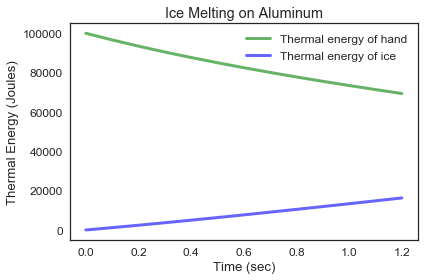

In [298]:
plot(results.thermal_energy_hand, 'g', label='Thermal energy of hand')
plot(results.thermal_energy_ice, 'b', label='Thermal energy of ice')
decorate(xlabel='Time (sec)', 
         ylabel='Thermal Energy (Joules)', 
         title='Ice Melting on Aluminum')

In [299]:
def calc_melt_time(results):
    """Returns the total runtime of simulation in seconds
    
    results: results of run_simulation

    returns: last index of TimeFrame 
    """
    return results.index[-1]

In [300]:
def sweep_material(params):
    """Sweeps through different materials to test how long ice would melt for each
    
    params:
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        plate_temp: temperature of the plate, in celsius 
        thickness: thickness of the plate, in meters

    returns: DataFrame with results of sweep
    """
    
    plate_materials, surface_area, plate_temp, thickness = params
    
    thermal_conductivity_factors = plate_materials['thermal_conductivity_factor']
    specific_heat_capacities = plate_materials['specific_heat_capacity']
    
    sweep = SweepSeries()
    for i in range(0, plate_materials['material'].size):
        system_params = Params(plate_materials['material'][i],
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[plate_materials['material'][i]] = calc_melt_time(results)
    return sweep

aluminum       1.2
nickel         2.3
marble        71.9
wood        1116.1
dtype: float64


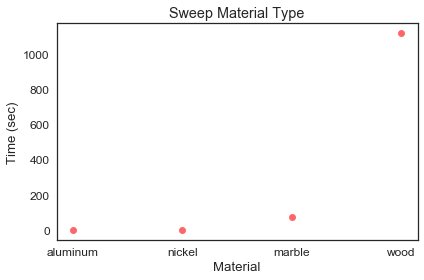

In [301]:
params = Params(plate_materials=plate_materials,
                surface_area=.05,
                plate_temp=23,
                thickness=.02)
sweep = sweep_material(params)

print(sweep)

plot(sweep, 'or')
decorate(xlabel='Material', 
         ylabel='Time (sec)', 
         title='Sweep Material Type')

In [302]:
def sweep_surface_area(params):
    """Sweeps through range of surface areas to test how long ice would melt for each
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        plate_temp: temperature of the plate, in celsius 
        thickness: thickness of the plate, in meters
        surface_area_array: list holding surface areas to test

    returns: DataFrame with results of sweep
    """
    
    material, plate_materials, plate_temp, thickness, surface_area_array = params
    sweep = SweepSeries()
    for surface_area in surface_area_array:
        system_params = Params(material=material,
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[system.surface_area]= calc_melt_time(results)
    return sweep

0.01    5.4
0.02    2.8
0.03    1.9
0.04    1.4
0.05    1.2
dtype: float64


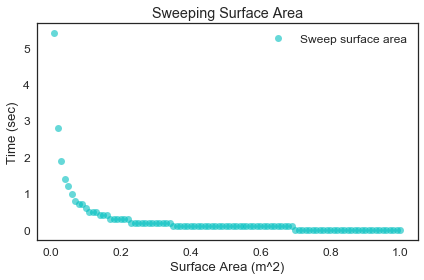

In [303]:
surface_area_array = linspace(0.01, 1, 100)

params = Params(material='aluminum',
                plate_materials=plate_materials,
                plate_temp=23,
                thickness=.02,
                surface_area_array=surface_area_array)
sweep = sweep_surface_area(params)

print(sweep.head())

plot(sweep, 'oc', label='Sweep surface area')
decorate(xlabel='Surface Area (m^2)', 
         ylabel='Time (sec)', 
         title='Sweeping Surface Area')

In [304]:
def sweep_plate_temp(params):
    """Sweeps through different plate temperatures to test how long ice would melt for each
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        thickness: thickness of the plate, in meters
        plate_temp_array: list holding plate temperatures to test

    returns: DataFrame with results of sweep
    """
    
    material, plate_materials, surface_area, thickness, plate_temp_array = params
    sweep = SweepSeries()
    for plate_temp in plate_temp_array:
        system_params = Params(material=material,
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[system.plate_temp]= calc_melt_time(results)
    return sweep

0     1.7
5     1.6
10    1.5
15    1.4
20    1.2
dtype: float64


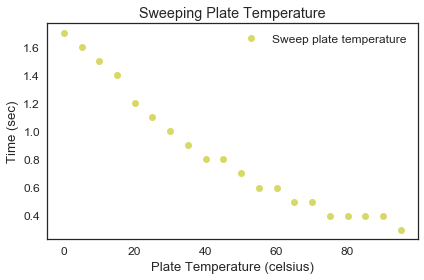

In [305]:
plate_temp_array = linrange(0, 100, 5)

params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=.05,
                thickness=.02,
                plate_temp_array=plate_temp_array)
sweep = sweep_plate_temp(params)

print(sweep.head())

plot(sweep, 'yo', label='Sweep plate temperature')
decorate(xlabel='Plate Temperature (celsius)', 
         ylabel='Time (sec)', 
         title='Sweeping Plate Temperature')

In [306]:
def sweep_thickness(params):
    """Sweeps through different thicknesses to test how long ice would melt for each
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        plate_temp: temperature of the plate, in celsius 
        thickness_array: list holding thicknesses to test

    returns: DataFrame with results of sweep
    """
    
    material, plate_materials, surface_area, plate_temp, thickness_array = params
    sweep = SweepSeries()
    for thickness in thickness_array:
        system_params = Params(material=material,
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[system.thickness]= calc_melt_time(results)
    return sweep

0.010000    0.7
0.062105    3.1
0.114211    5.3
0.166316    7.6
0.218421    9.8
dtype: float64


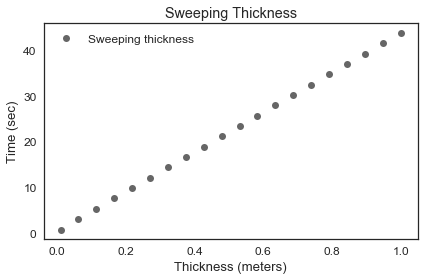

In [307]:
thickness_array = linspace(0.01, 1, 20)

params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=.05,
                plate_temp=23,
                thickness_array=thickness_array)
sweep = sweep_thickness(params)

print(sweep.head())

plot(sweep, 'ko', label='Sweeping thickness')
decorate(xlabel='Thickness (meters)', 
         ylabel='Time (sec)', 
         title='Sweeping Thickness')
    

Here we run a simulation of the extreme cases of each paramter to see how quickly ice could potentially melt (unrealistic scenario):

In [308]:
params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=1,
                plate_temp=100,
                thickness=.01,
                dt=.001)
system = make_system(params)
results = run_simulation(system, update_func)

,thermal_energy_hand,thermal_energy_ice,plate_temp
0.000,100000,0,100
0.001,101526,2050,99.8524
0.002,103048,4096.97,99.705
0.003,104567,6140.93,99.5579
0.004,106082,8181.86,99.4111
0.005,107593,10219.8,99.2645
0.006,109101,12254.7,99.1182
0.007,110606,14286.6,98.9722
0.008,112107,16315.6,98.8265


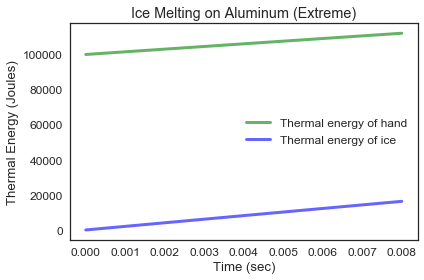

In [309]:
plot(results.thermal_energy_hand, 'g', label='Thermal energy of hand')
plot(results.thermal_energy_ice, 'b', label='Thermal energy of ice')
decorate(xlabel='Time (sec)', 
         ylabel='Thermal Energy (Joules)', 
         title='Ice Melting on Aluminum (Extreme)')